In [ ]:
import csv
import cv2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB2, EfficientNetB4
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import json

In [ ]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
images_path = "./gdrive/MyDrive/lumen/data/"
annotations_path = "./gdrive/MyDrive/lumen/processed_annotations.csv"
train_annotations_path = "./gdrive/MyDrive/lumen/train_annotations.csv"
validation_annotations_path = "./gdrive/MyDrive/lumen/validation_annotations.csv"
test_annotations_path = "./gdrive/MyDrive/lumen/test_annotations.csv"
model_path = "./gdrive/MyDrive/models/region_guessr_reg_eff_net_mdl_wts.hdf5" 
full_model_path = "./gdrive/MyDrive/models/region_guessr_reg_eff_net_full_mdl"
IMAGE_SIZE = 128           
BATCH_SIZE = 128

In [ ]:
def build_model():
  inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  # model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet")
  # model.trainable = False
  model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet")
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)
  top_dropout_rate = 0.1
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mean_squared_error"])
  return model

In [ ]:
train_records_path = "./gdrive/MyDrive/tf_records/regression_train"
validation_records_path = "./gdrive/MyDrive/tf_records/regression_validation"

In [ ]:
TRAIN_FILENAMES = tf.io.gfile.glob(train_records_path + "/*.tfrecords")
print(train_records_path + "/train*.tfrec")
print("Train TFRecord Files:", len(TRAIN_FILENAMES))

VAL_FILENAMES = tf.io.gfile.glob(validation_records_path + "/*.tfrecords")
print(validation_records_path + "/validation*.tfrec")
print("Train TFRecord Files:", len(VAL_FILENAMES))

AUTOTUNE = tf.data.AUTOTUNE

./gdrive/MyDrive/tf_records/regression_train/train*.tfrec
Train TFRecord Files: 5
./gdrive/MyDrive/tf_records/regression_validation/validation*.tfrec
Train TFRecord Files: 1


In [ ]:
def parse_tfr_element(element):
  data = {
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'x_coord' : tf.io.FixedLenFeature([], tf.float32),
      'y_coord' : tf.io.FixedLenFeature([], tf.float32)
    }

    
  content = tf.io.parse_single_example(element, data)
  
  x = content['x_coord']
  y = content['y_coord']
  raw_image = content['raw_image']
  
  
  feature = tf.io.parse_tensor(raw_image, out_type=tf.uint8)
  feature = tf.reshape(feature, shape=[128, 128,3])
  return (feature, [x, y])

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [ ]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
          'raw_image' : tf.io.FixedLenFeature([], tf.string),
          'x_coord' : tf.io.FixedLenFeature([], tf.float32),
          'y_coord' : tf.io.FixedLenFeature([], tf.float32)
        }
        if labeled
        else {"raw_image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["raw_image"])
    if labeled:
        x = tf.cast(example["x"], tf.float32)
        y = tf.cast(example["y"], tf.float32)
        return image, [x, y]
    return image

In [ ]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        parse_tfr_element, num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [ ]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_dataset = get_dataset(TRAIN_FILENAMES)
validation_dataset = get_dataset(VAL_FILENAMES)

In [ ]:
model = build_model()
epochs = 25
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
# model.load_weights(model_path)  ##Ukljuciti ako zelimo nastaviti od zadnjeg treninga, iskljuciti ako zelimo poceti od nule
# model.fit(x=x, y=y, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1, verbose=1, callbacks=[model_checkpoint_callback], shuffle=True)
# model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=epochs, validation_data=validation_dataset, verbose=1, callbacks=[model_checkpoint_callback], shuffle=True)

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
model.load_weights(model_path)
# model.evaluate(train_dataset)
model.evaluate(validation_dataset)

In [ ]:
def visualise_sample(pred, ground, map_path):
  map = cv2.imread(map_path)
  plt.figure()
  plt.imshow(cv2.flip(map, 0))

  current_axis = plt.gca()
  plt.gca().invert_yaxis()

  x0 = pred[0] * map.shape[0]
  y0 = pred[1] * map.shape[1]
  current_axis.add_patch(plt.Circle((x0, y0), 20, color="red", fill=True, linewidth=2))

  x0 = ground[0] * map.shape[0]
  y0 = ground[1] * map.shape[1]
  current_axis.add_patch(plt.Circle((x0, y0), 20, color="blue", fill=True, linewidth=2))

In [ ]:
def transform(json_x_path, json_y_path, data):
  with open(json_x_path, 'r') as file:
    transformation_x = json.load(file)
  with open(json_y_path, 'r') as file:
    transformation_y = json.load(file)
  transformed_data = []
  for coords in data:
    transformed = []
    for trans in transformation_x:
      if coords[1] <= trans["target_range_end"]:
        range_perc = (coords[1] - trans["target_range_start"])/(trans["target_range_end"] - trans["target_range_start"])
        transformed.append(range_perc * (trans["original_range_end"] - trans["original_range_start"]) + trans["original_range_start"])
        if range_perc * (trans["original_range_end"] - trans["original_range_start"]) + trans["original_range_start"] > 1:
          print("Error: x is bigger then 1")
        break
    for trans in transformation_y:
      if coords[0] <= trans["target_range_end"]:
        range_perc = (coords[0] - trans["target_range_start"])/(trans["target_range_end"] - trans["target_range_start"])
        transformed.append(range_perc * (trans["original_range_end"] - trans["original_range_start"]) + trans["original_range_start"])
        if range_perc * (trans["original_range_end"] - trans["original_range_start"]) + trans["original_range_start"] > 1:
          print("Error: y is bigger then 1")
        break
    transformed_data.append(transformed)
  return transformed_data

In [ ]:
# train_predictions = model(train_dataset)
# val_predictions = model(validation_dataset)

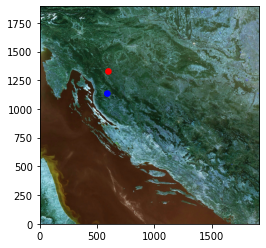

Error in callback <function flush_figures at 0x7f1ef5ee7950> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
json_x_path = "./gdrive/MyDrive/lumen/transforms/x.json"
json_y_path = "./gdrive/MyDrive/lumen/transforms/y.json"
map_path = "./gdrive/MyDrive/lumen/croatia-satellite-map.jpg"

sample, sample_coords = next(iter(validation_dataset))
# print(sample_coords)
sample_predictions = model(sample)
sample_predictions = transform(json_x_path=json_x_path, json_y_path=json_y_path, data=sample_predictions)

sample_coords = transform(json_x_path=json_x_path, json_y_path=json_y_path, data=sample_coords)
for i in range(len(sample_predictions[:20])):
  visualise_sample(pred=sample_predictions[i], ground=sample_coords[i], map_path=map_path)

In [ ]:
model.save(full_model_path)

INFO:tensorflow:Assets written to: ./gdrive/MyDrive/models/region_guessr_reg_eff_net_full_mdl/assets
